In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# home brew utitilties
# import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md
from IPython.display import Image

# Cordova Creek 

Cordova Creek was orginally named Clifton drain which is/was a concrete channel established for evacuating runoff to the American River. The Cordova Creek Naturalization Project (CCNP) started in early 2016 with the goal of restoring natural form and function to a portion of the channelized stream. The naturalized waterway, which provides both critical habitat and water quality benefits, was renamed Cordova Creek. 

The River Bend Park Area at the time the plan called for the restoration of Cordova Creek to create a riparian corridor that would filter urban runoff and serve as a buffer between the nature study area to the west and the developed recreational uses to the east. It also calls for bringing together native plant nursery, organic farming operations and riparian habitat to enhance interpretation opportunities.

## Monitoring aquatic litter

In 2015 we began a project with a goal to quantify the debris flowing to the American River and one of its tributaries: Cordova Creek. The surveys followed the protocol described in _The Guide for Monitoriing litter on European seas_ :

1. Take pictures of location, including visible debris present
2. Note location, date, length of survey area
3. Remove all visible debris items from within the survey perimeter using standard retrieval methods/equipment
4. Place all debris items on a tarp
5. Count and photograph the array of items
6. Enter data in the survey app
7. Once all items have been documented dispose, or recycle

Surveys were conducted weekly on Wednesday morninging and anounced via social media in advance. The surveyor maintained a blog with an entry for most surveys [hammerdirt at riverbend](https://hammerdirtriverbend.blogspot.com). 

__Figure 1:__ Aerial image of the CCNP. The survey location from 2015-2017 was right at the confluence with the American river. The Cordova Creek II project would add an aditional site at the start of the CCNP.

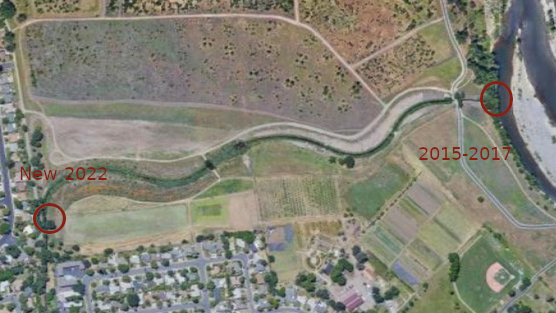

In [2]:
Image("resources/images/map.png")

## Survey Results 

There were 56 surveys completed between November 2015 and April 2017 (Figure 1). The median survey results was 5 pieces of trash  per meter (pcs/m), the average was 6 pcs/m (Table 1). Plastic comprised 80% of the inventory the next closest were metal and paper $\approxeq$ 7% (Table 2).

__Left Figure 2:__ The total for each survey. __Right Figure 3:__ The cumlative distribution of the results

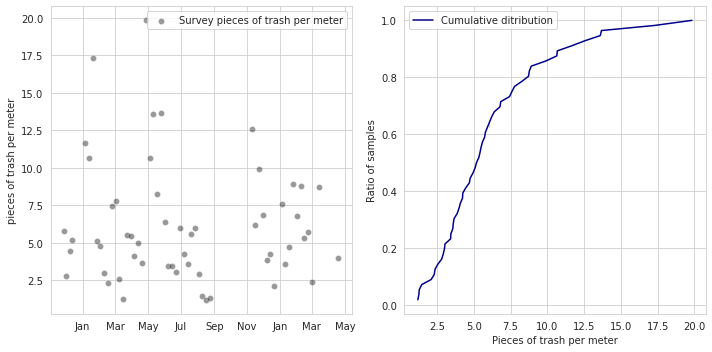

In [3]:
# using the server data
server_data = pd.read_csv('resources/the_data.csv')
unit_label = "pcs_m"

# drop unnamed column:
def drop_this_column(data, column='Unnamed: 0'):
    if column in data.columns:
        data.drop(column, inplace=True, axis=1)
for datas in [server_data]:
    drop_this_column(datas)

fd = server_data[server_data.location == 'cordova-creek'].copy()
fd["loc_date"] = list(zip(fd["location"], fd["date"]))
fd["date"] = pd.to_datetime(fd["date"])
fd["month"] = fd["date"].dt.month

# number of samples
nsamps = fd.loc_date.unique()

# total quantity
qty = fd.quantity.sum()

# avg qty
avg_qty = fd.groupby("loc_date").quantity.sum().mean()

# average and median pcs/m
avg_pcsm = fd.groupby("loc_date").pcs_m.sum().mean()
md_pcsm = fd.groupby("loc_date").pcs_m.sum().median()

# daily totals
dts_date = fd.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
dts_date["month"] = dts_date["date"].map(lambda x: x.month)

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
# months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)
sns.set_style("whitegrid")

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(x=dts_date["date"], y=dts_date["pcs_m"], label="Survey pieces of trash per meter", color="black", alpha=0.4,  ax=ax)

ax.set_ylabel("pieces of trash per meter")
ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dts_date[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label="Cumulative ditribution")

axtwo.set_xlabel("Pieces of trash per meter") 
axtwo.set_ylabel("Ratio of samples")

plt.tight_layout()
plt.show()

__Left Table 1:__ Summary of survey results. __Right Table 2:__ Material type and totals.

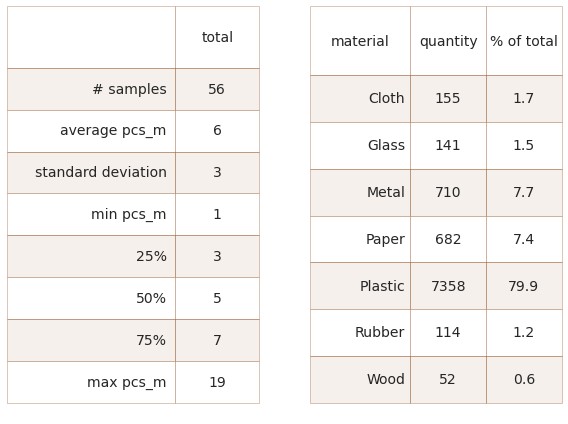

In [4]:
# get the basic statistics from pd.describe
cs = dts_date[unit_label].describe().round(2)

# change the names 
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# map code description
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# common aggregations
code_map = dfCodes[["code", "description"]].set_index("code")
material_map = dfCodes[["code", "material"]].set_index("code")

agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}
 
fd["material"] = fd.code.map(lambda x: material_map.loc[x][0])
mattotals = fd.groupby('material', as_index=False).quantity.sum()
mattotals["% of total"] = ((mattotals.quantity/mattotals.quantity.sum())*100).round(1)
mat_data = mattotals[["material", "quantity", "% of total"]].copy()

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = ["name", "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, mat_data.values,  colLabels=mat_data.columns, colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
# table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## The most common objects

Foam polystyrene was the most by quantity however snack wrappers were found at a greater percentage of the surveys. Fractured plastics and polystyrene were found more often than cigarettes  (Table 3),

__Table 3:__ The twenty most common items from 2015-2017

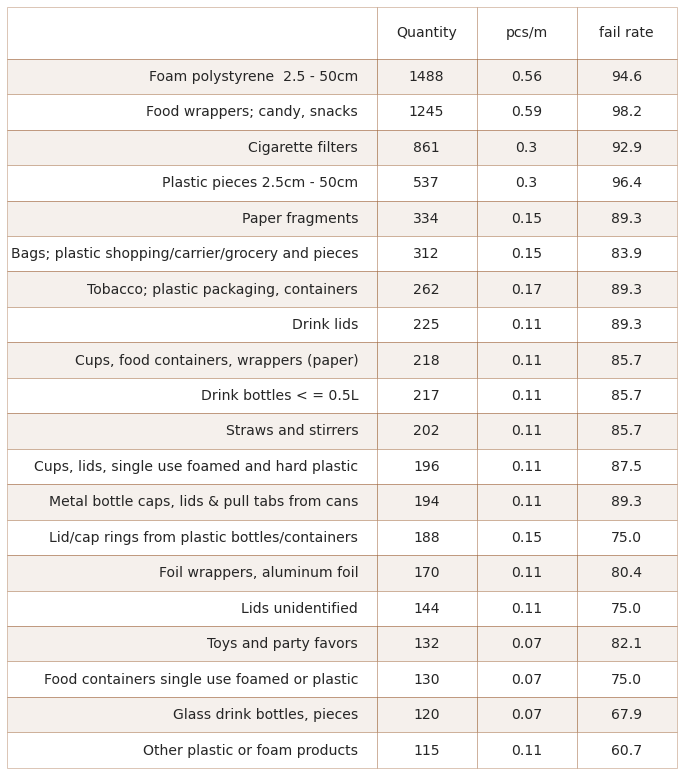

In [5]:
# the top 20 codes
codes = fd.groupby(['loc_date','code'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
codes["fail"] = codes.quantity > 0
codes = codes.groupby("code").agg({'quantity':'sum', 'pcs_m':'median', 'fail':'sum'})
codes["fail rate"] = ((codes.fail/56)*100).round(1)
codes["pcs_m"] = codes["pcs_m"].round(2)
top_20 = codes.sort_values(by="quantity", ascending=False)[:20]
top_20 = top_20.reset_index()

# map code description
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
code_map = dfCodes[["code", "description"]].set_index("code")

top_20["description"] = top_20.code.map(lambda x: code_map.loc[x][0])
table_vals = ["description", "quantity", "pcs_m", "fail rate"]

table_data = top_20[table_vals].copy()
table_data.rename(columns={"quantity":"Quantity", "pcs_m":"pcs/m"}, inplace=True)

# make table
data = table_data
colLabels = table_data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*3,len(data)*.7))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, a_color="saddlebrown", colWidths=[.48, *[.13]*4])
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()


__Figure 4:__ January and February survey results. Samples were collected in 2022, the results were lower than the median  value for those two months (6.25 pcs/m).

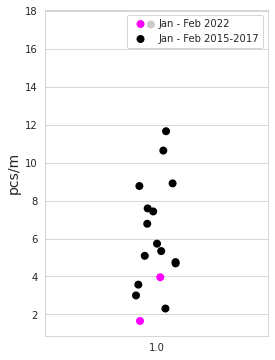

In [6]:

# path = "resources/CC_BRC_bag_1.csv"

def totals(path, anarray): 
    
    new_data = pd.read_csv(path)
    
    
    
    if "cordovacreek" in new_data.columns:
        newarray = ['date', 'code', 'quantity', 'cordovacreek', 'loc_date']
    
    else:
        newarray = anarray
        
    
    new_data= new_data[newarray]
    
    nd_total = new_data.quantity.sum()
    nd_pcsm = nd_total/26
    return nd_total, nd_pcsm

paths = ["resources/1_6_22.csv","resources/02_03_22.csv"]
anarray=['date', 'code', 'quantity', 'location', 'loc_date']
results = dict(jan=(), feb=())

res = []
for path in paths:    
    res.append(totals(path, anarray))
    
fig, ax = plt.subplots(figsize=(4,6))


sns.stripplot(x=[1,1], y=[res[1][1], res[0][1]], color="magenta", size=8, ax=ax, label= "Jan - Feb 2022")
# january february
jan_feb = dts_date[dts_date["month"].isin([1,2])]

sns.stripplot(x=np.ones(len(jan_feb)), y=jan_feb["pcs_m"].values, color="black", size=8, label="Jan - Feb 2015-2017", ax=ax)
# sns.stripplot(x=np.ones(len(dts_date)), y=dts_date["pcs_m"].values, color="black", alpha=0.5, zorder=0, ax=ax)
ax.set_ylabel("pcs/m", fontsize=14)
ax.legend()
plt.show()

## Discussion

Cordova Creek I is unique because of the number of samples at one location in a relatively shore period of time. As reference the EU recommends 40 samples over a six year period to establish a baseline using this protocol, there were 56 samples in 18 months at Cordova Creek I. In light of state Water Resources Control Board (RS2015-0019) {cite}`rs20150019` the concept of measuring the flow of trash to recieving waters is improtant to determimiing degress of success. This has increased research in the topic. For example, identifying locations in a municpality that may contribute to that flow {cite}`salinas2015` or investigating different monitoring techniques {cite}`sfeihale` the state of California and stae universities are actively looking for solutions. Replicating the Cordova Creek Project would provide valuable information regarding the real reduction of trash flow before, and after a naturalization project. To our knowledge, no such study exists.

The types of objects that are found is of interest to those who    seek to reduce emissions from storm water systems. Recently U.C. Riverside produced an application to help standardize the typology of the objects indentified in a survey {cite}`cowger`. According to this study the data produced using the JRC protocol, was among the methods with the highest comparability values on average for material and item types, thus validating the choice of method in 2015 by hammerdirt california at cordova creek 1.

Results from  surveys in Jan , and Feb 2022 (fig. 4), suggests that there may be a measurable decrease of the number of objects per meter (or meter squared), at the confluence of Cordova Creek and the lower American River. The final phase of CCNP (scheduled 2024-2025) is an opportunity to quantify the beneficial effects of naturalization projects in reference to SWRCB 2015-0019.